# Linear Transformations

## Introduction

Linear transformations are a valuable tool to help make your linear regression model more interpretable. They can involve transforming the scale, the mean, or both.

## Objectives

You will be able to:

* Determine if a linear transformation would be useful for a specific model or set of data
* Identify an appropriate linear transformation technique for a specific model or set of data
* Apply linear transformations to independent and dependent variables in linear regression
* Interpret the coefficients of variables that have been transformed using a linear transformation

## Why Apply Linear Transformations?

Linear transformations don't impact the overall model performance metrics of an ordinary least-squares linear regression. So why apply them?

The main reason to apply a linear transformation is so that the modeling results are **more useful or interpretable to a stakeholder**. There are also some machine learning models that assume that variables have been transformed to have the same scale, although this is not applicable to the regression models we are currently using.

For each common type of linear transformation we'll walk through a reason why it might be useful, how to apply it, and how to interpret the resulting coefficients.

## Scaling

Let's say we have this model, using the Auto MPG dataset:

In [3]:
import pandas as pd
data = pd.read_csv("auto-mpg.csv")
data

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
387,27.0,4,140.0,86,2790,15.6,82,1,ford mustang gl
388,44.0,4,97.0,52,2130,24.6,82,2,vw pickup
389,32.0,4,135.0,84,2295,11.6,82,1,dodge rampage
390,28.0,4,120.0,79,2625,18.6,82,1,ford ranger


In [4]:
import statsmodels.api as sm

y_initial = data["mpg"]
X_initial = data[["cylinders", "weight", "model year"]]

initial_model = sm.OLS(y_initial, sm.add_constant(X_initial))
initial_results = initial_model.fit()

In [5]:
initial_results.rsquared_adj

0.8069069309563752

In [6]:
initial_results.params

const        -13.907606
cylinders     -0.151729
weight        -0.006366
model year     0.752020
dtype: float64

You are preparing to present these findings to your stakeholders when you realized that all of the units are **imperial** but your stakeholders are used to the **metric** system. None of your coefficients are going to make any sense to them!

To address this issue, you can apply ***scaling*** to the variables. This just means multiplying the variables by an appropriate value. We'll use pandas broadcasting to multiply everything in a column at once.

### Scaling a Feature

First we'll start by scaling the `weight` predictor so that the units are kilograms rather than pounds.

In [7]:
X_metric = X_initial.copy()
# 1 lb = 0.45 kg
X_metric["weight"] = X_metric["weight"] * 0.453592

X_metric

,cylinders,weight,model year
0,8,1589.386368,70
1,8,1675.115256,70
2,8,1558.542112,70
3,8,1557.181336,70
4,8,1564.438808,70
...,...,...,...
387,4,1265.521680,82
388,4,966.150960,82
389,4,1040.993640,82
390,4,1190.679000,82


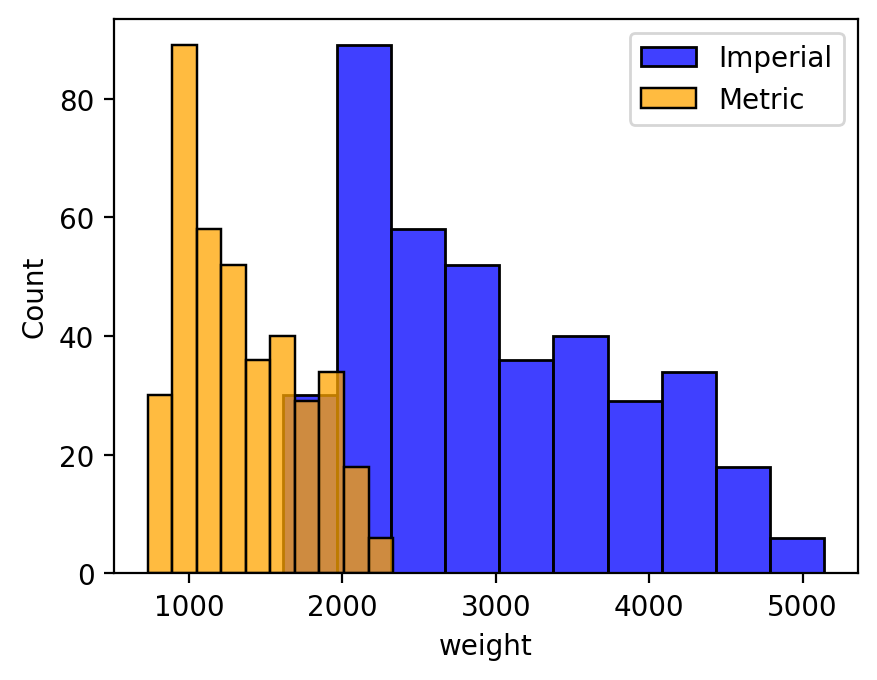

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots()
sns.histplot(data=X_initial, x="weight", label="Imperial", ax=ax, color="blue")
sns.histplot(data=X_metric, x="weight", label="Metric", color="orange", ax=ax)
ax.legend();

In [9]:
kg_model = sm.OLS(y_initial, sm.add_constant(X_metric))
kg_results = kg_model.fit()

print(f"""
Initial model adjusted R-Squared:      {initial_results.rsquared_adj}
Weight in kg model adjusted R-Squared: {kg_results.rsquared_adj}
""")


Initial model adjusted R-Squared:      0.8069069309563752
Weight in kg model adjusted R-Squared: 0.8069069309563754



We have just built the "same" model, as you can see from the comparison of adjusted R-Squared values. But now let's look at the coefficients:

In [10]:
initial_results.params

const        -13.907606
cylinders     -0.151729
weight        -0.006366
model year     0.752020
dtype: float64

In [11]:
kg_results.params

const        -13.907606
cylinders     -0.151729
weight        -0.014034
model year     0.752020
dtype: float64

They are all the same except for `weight`. The coefficient for `weight` still has the same sign (negative) but it's representing a different scale of weight.

The initial model is saying:

> For each increase of 1 lb in weight, we see an associated decrease of about .006 in MPG

The second model is saying:

> For each increase of 1 kg in weight, we see an associated decrease of about .014 in MPG

This is telling you the exact same information, just expressed in different units.

We actually could have calculated this without building an entire new model! We would just apply the inverse of the same transformation to the coefficient that we applied to the feature.

In [12]:
kg_results.params["weight"]

-0.014033972159815949

In [13]:
initial_results.params["weight"] / 0.453592

-0.014033972159816274

### Scaling the Target

But you'll notice that even though we adjusted the units of `weight`, the target units are still in miles per gallon, which uses imperial units. The conventional metric units for fuel economy are kilometers per liter, not miles per gallon. For this to make sense to our stakeholders we need to make sure that all of the units are metric, not imperial.

So let's transform the units of `y` as well:

In [14]:
# 1 mpg = 0.425 km/L
y_metric = data["mpg"] * 0.425144
# "mpg" is no longer an accurate name, so rename
y_metric.name = "km/L"

y_metric

0       7.652592
1       6.377160
2       7.652592
3       6.802304
4       7.227448
         ...    
387    11.478888
388    18.706336
389    13.604608
390    11.904032
391    13.179464
Name: km/L, Length: 392, dtype: float64

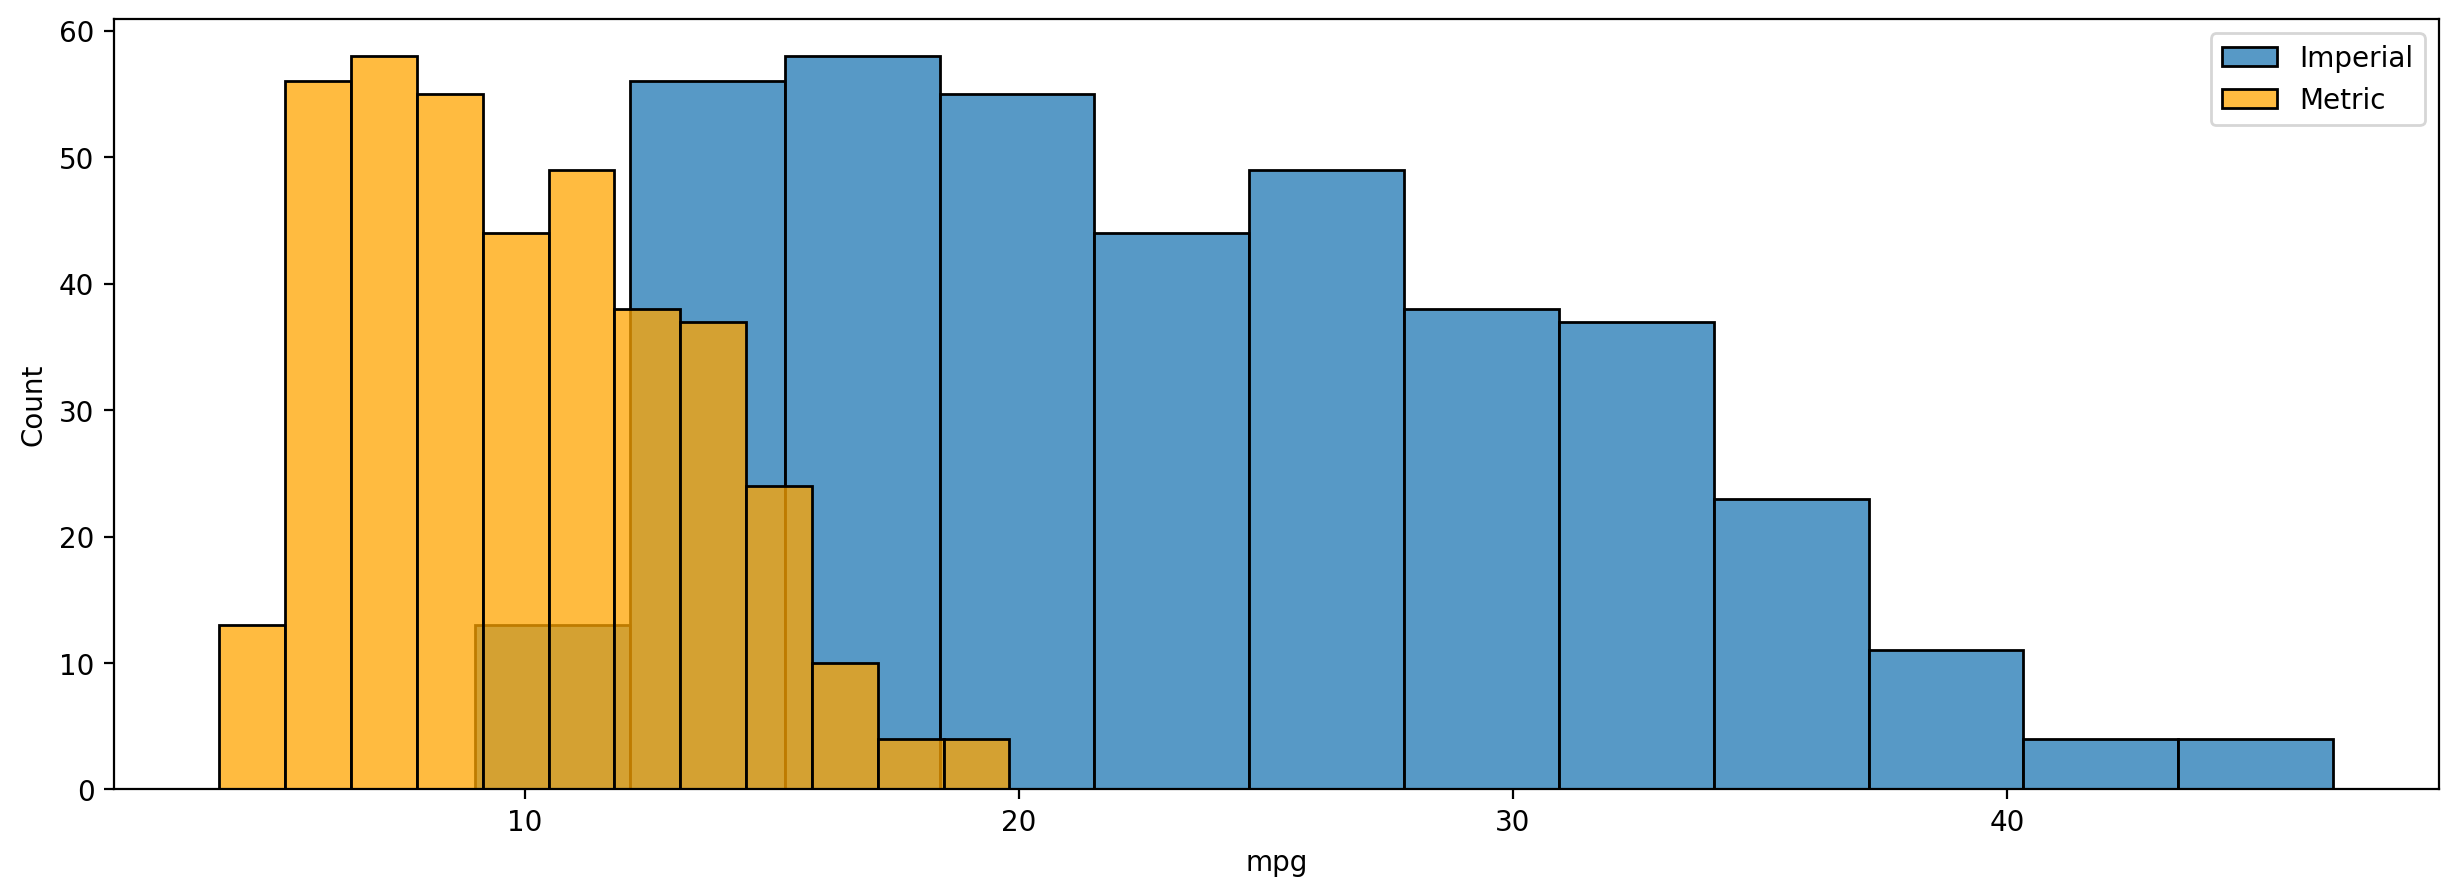

In [15]:
fig, ax = plt.subplots(figsize=(15,5))
sns.histplot(data=y_initial, label="Imperial", ax=ax)
sns.histplot(data=y_metric, label="Metric", color="orange", ax=ax)
ax.legend();

In [16]:
metric_model = sm.OLS(y_metric, sm.add_constant(X_metric))
metric_results = metric_model.fit()

print(f"""
Initial model adjusted R-Squared:      {initial_results.rsquared_adj}
Weight in kg model adjusted R-Squared: {kg_results.rsquared_adj}
Metric model adjusted R-Squared:       {metric_results.rsquared_adj}
""")


Initial model adjusted R-Squared:      0.8069069309563752
Weight in kg model adjusted R-Squared: 0.8069069309563754
Metric model adjusted R-Squared:       0.8069069309563752



In [17]:
kg_results.params

const        -13.907606
cylinders     -0.151729
weight        -0.014034
model year     0.752020
dtype: float64

In [18]:
metric_results.params

const        -5.912735
cylinders    -0.064507
weight       -0.005966
model year    0.319717
dtype: float64

We are still getting the same adjusted R-Squared, but our coefficients look quite different now that we've transformed the target.

Interpreting the `weight` coefficient specifically, the second model was saying:

> For each increase of 1 kg in weight, we see an associated decrease of about .014 in MPG

Whereas the model with a transformed target was saying:

> For each increase of 1 kg in weight, we see an associated decrease of about 0.006 in km/L

Again, this is the same information, except now both the predictor and the target are expressed in metric units.

Once again we _could_ have just transformed the coefficients rather than building a new model, but the math gets more complicated:

In [19]:
metric_results.params["weight"]

-0.0059664590599128

In [20]:
# For target transformations, don't invert
# --> We multiplied the target, so multiply the coefficient
kg_results.params["weight"] * 0.425144

-0.005966459059912792

In [21]:
# To go from the original values, both divide and multiply
# --> We multiplied the predictor, so divide the coefficient
# --> We multiplied the target, so multiply the coefficient
initial_results.params["weight"] / 0.453592 * 0.425144

-0.00596645905991293

The key takeaway here is that **when you apply scaling, you are building the same model, except it is expressed using different units**. You can change the units either before or after fitting the model.

## Shifting

While scaling means multiplying/dividing variables, shifting means **adding or subtracting** a value from the variable. Scaling impacts the predictor coefficients, whereas shifting impacts the constant coefficient (i.e. the intercept).

### Shifting to Improve Dataset Interpretability

One example of shifting might be if we wanted to change the values of `model year` so that instead of being "years since 1900" (e.g. 70) they are just "years CE" (e.g. 1970).

In [22]:
X_years_ce = X_initial.copy()
X_years_ce["model year"] = X_years_ce["model year"] + 1900
X_years_ce

,cylinders,weight,model year
0,8,3504,1970
1,8,3693,1970
2,8,3436,1970
3,8,3433,1970
4,8,3449,1970
...,...,...,...
387,4,2790,1982
388,4,2130,1982
389,4,2295,1982
390,4,2625,1982


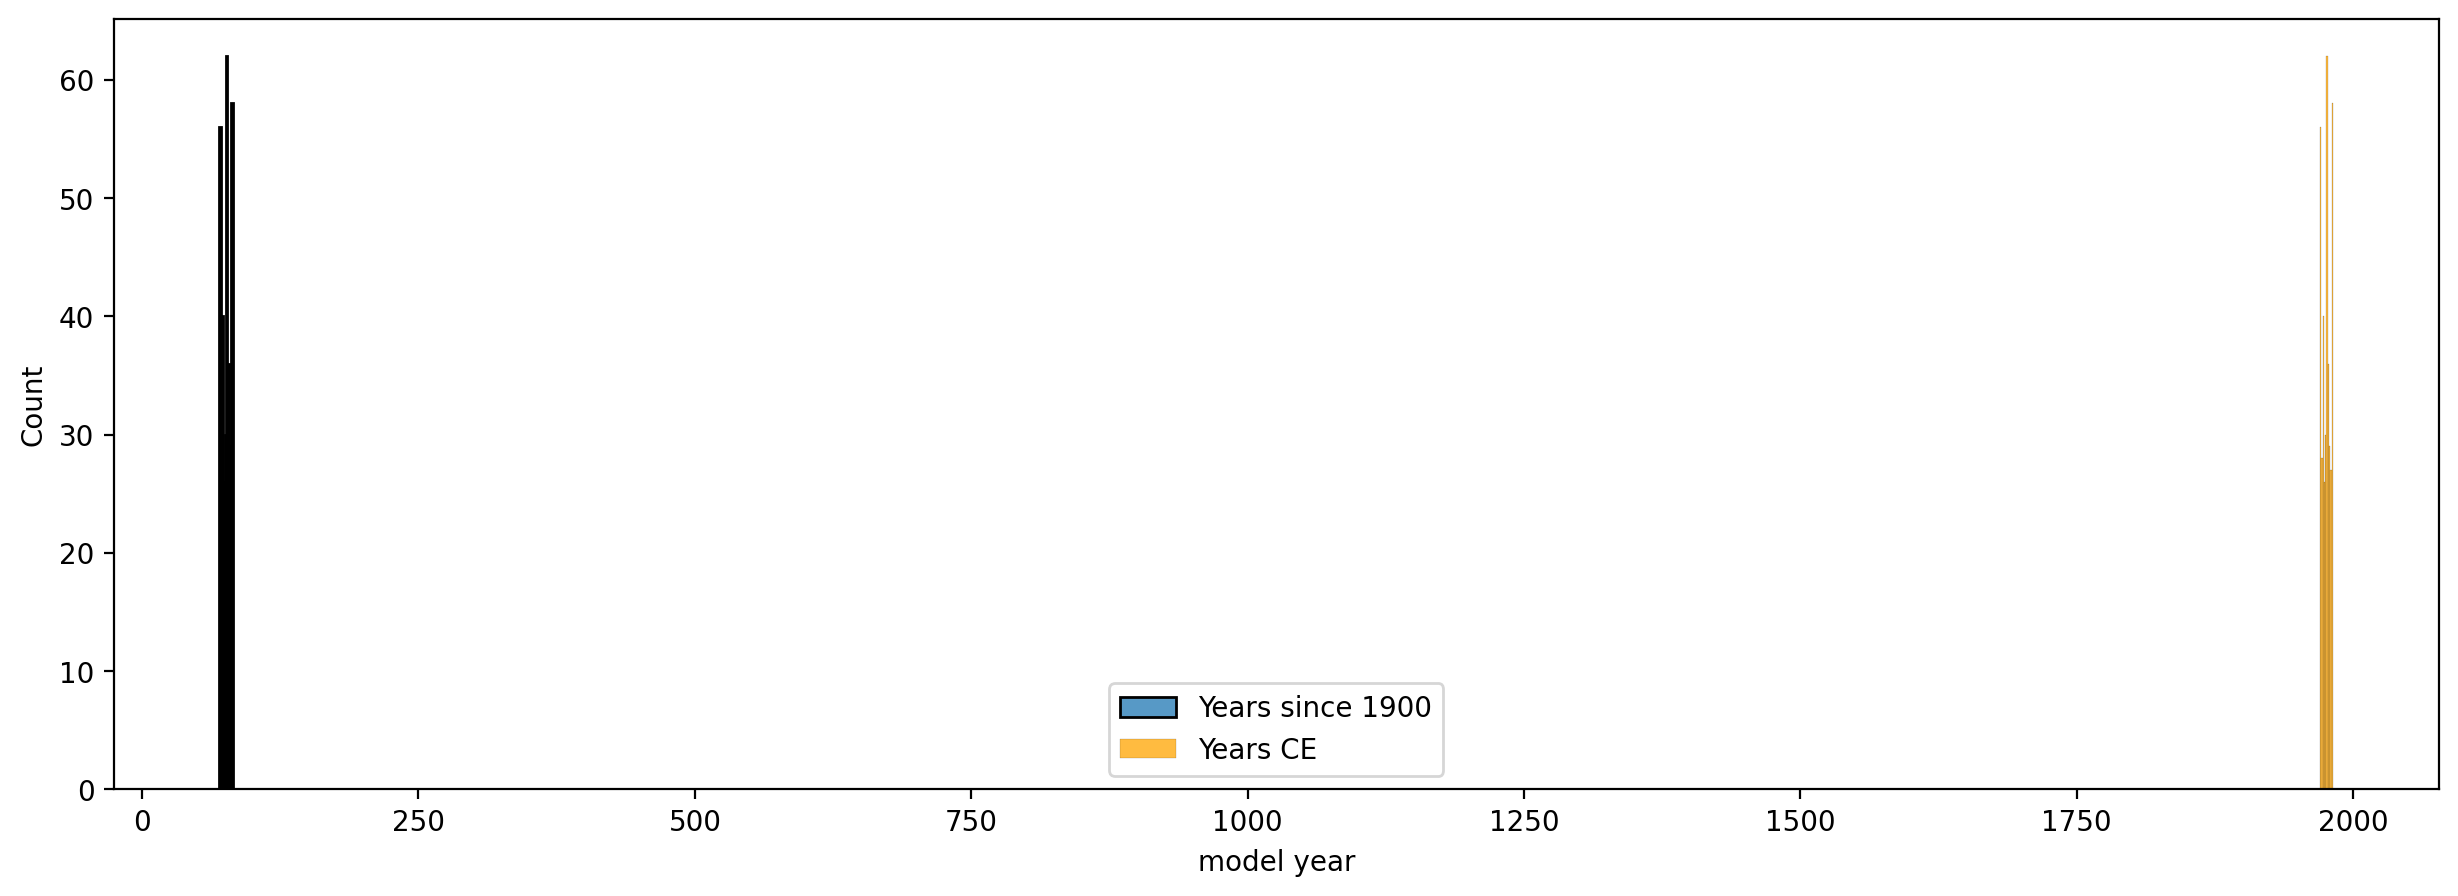

In [23]:
fig, ax = plt.subplots(figsize=(15,5))
sns.histplot(data=X_initial, x="model year", label="Years since 1900", ax=ax)
sns.histplot(data=X_years_ce, x="model year", label="Years CE", color="orange", ax=ax)
ax.legend();

This makes the dataset easier to understand, and potentially avoids some Y2K type errors. The resulting model has the same adjusted R-Squared and the same coefficients for everything except `const`:

In [24]:
years_ce_model = sm.OLS(y_initial, sm.add_constant(X_years_ce))
years_ce_results = years_ce_model.fit()

print(f"""
Initial model adjusted R-Squared:     {initial_results.rsquared_adj}
Years in CE model adjusted R-Squared: {kg_results.rsquared_adj}
""")


Initial model adjusted R-Squared:     0.8069069309563752
Years in CE model adjusted R-Squared: 0.8069069309563754



In [25]:
initial_results.params

const        -13.907606
cylinders     -0.151729
weight        -0.006366
model year     0.752020
dtype: float64

In [26]:
years_ce_results.params

const        -1442.745699
cylinders       -0.151729
weight          -0.006366
model year       0.752020
dtype: float64

The intercept (`const` coefficient) is not particularly interpretable either way.

In the first model, it is saying:

> For a car with 0 cylinders, weighing 0 lbs, and built in 1900, we expect an MPG of about -14

In the newest model, it is saying:

> For a car with 0 cylinders, weighing 0 lbs, and built in 0, we expect an MPG of about -1400

Neither of those hypothetical cars are particularly realistic, so we haven't really "broken" anything by making our dataset more interpretable.

It is possible to compute this change after the fact, but the math is more complex so we won't be demonstrating it. If you want to shift your data, it makes more sense to do it before building the model.

### Shifting to Improve Intercept Interpretability

In all of the examples so far, the intercept has been an impossible value (negative fuel economy) resulting from an impossible set of predictor values (e.g. weight of 0). What if we want to calculate a more interpretable intercept instead?

To do this we'll shift the predictors so that **a value of 0 represents the mean** rather than representing 0. This specific approach is typically called zero-centering (or simply ***centering***) and some machine learning models work much better with data centered around 0.

Note that this is essentially the opposite approach of shifting to make the dataset more interpretable. You will need to consider whether an interpretable dataset matters more, or an interpretable intercept matters more, for your particular context. You also might find that you need to build and report on multiple models to express these different aspects.

In [27]:
X_initial.describe()

,cylinders,weight,model year
count,392.000000,392.000000,392.000000
mean,5.471939,2977.584184,75.979592
std,1.705783,849.402560,3.683737
min,3.000000,1613.000000,70.000000
25%,4.000000,2225.250000,73.000000
50%,4.000000,2803.500000,76.000000
75%,8.000000,3614.750000,79.000000
max,8.000000,5140.000000,82.000000


In [28]:
X_centered = X_initial.copy()

for col in X_centered.columns:
    X_centered[col] = X_centered[col] - X_centered[col].mean()
    
X_centered.describe()

,cylinders,weight,model year
count,3.920000e+02,3.920000e+02,3.920000e+02
mean,-7.250436e-17,3.712223e-14,-4.640279e-15
std,1.705783e+00,8.494026e+02,3.683737e+00
min,-2.471939e+00,-1.364584e+03,-5.979592e+00
25%,-1.471939e+00,-7.523342e+02,-2.979592e+00
50%,-1.471939e+00,-1.740842e+02,2.040816e-02
75%,2.528061e+00,6.371658e+02,3.020408e+00
max,2.528061e+00,2.162416e+03,6.020408e+00


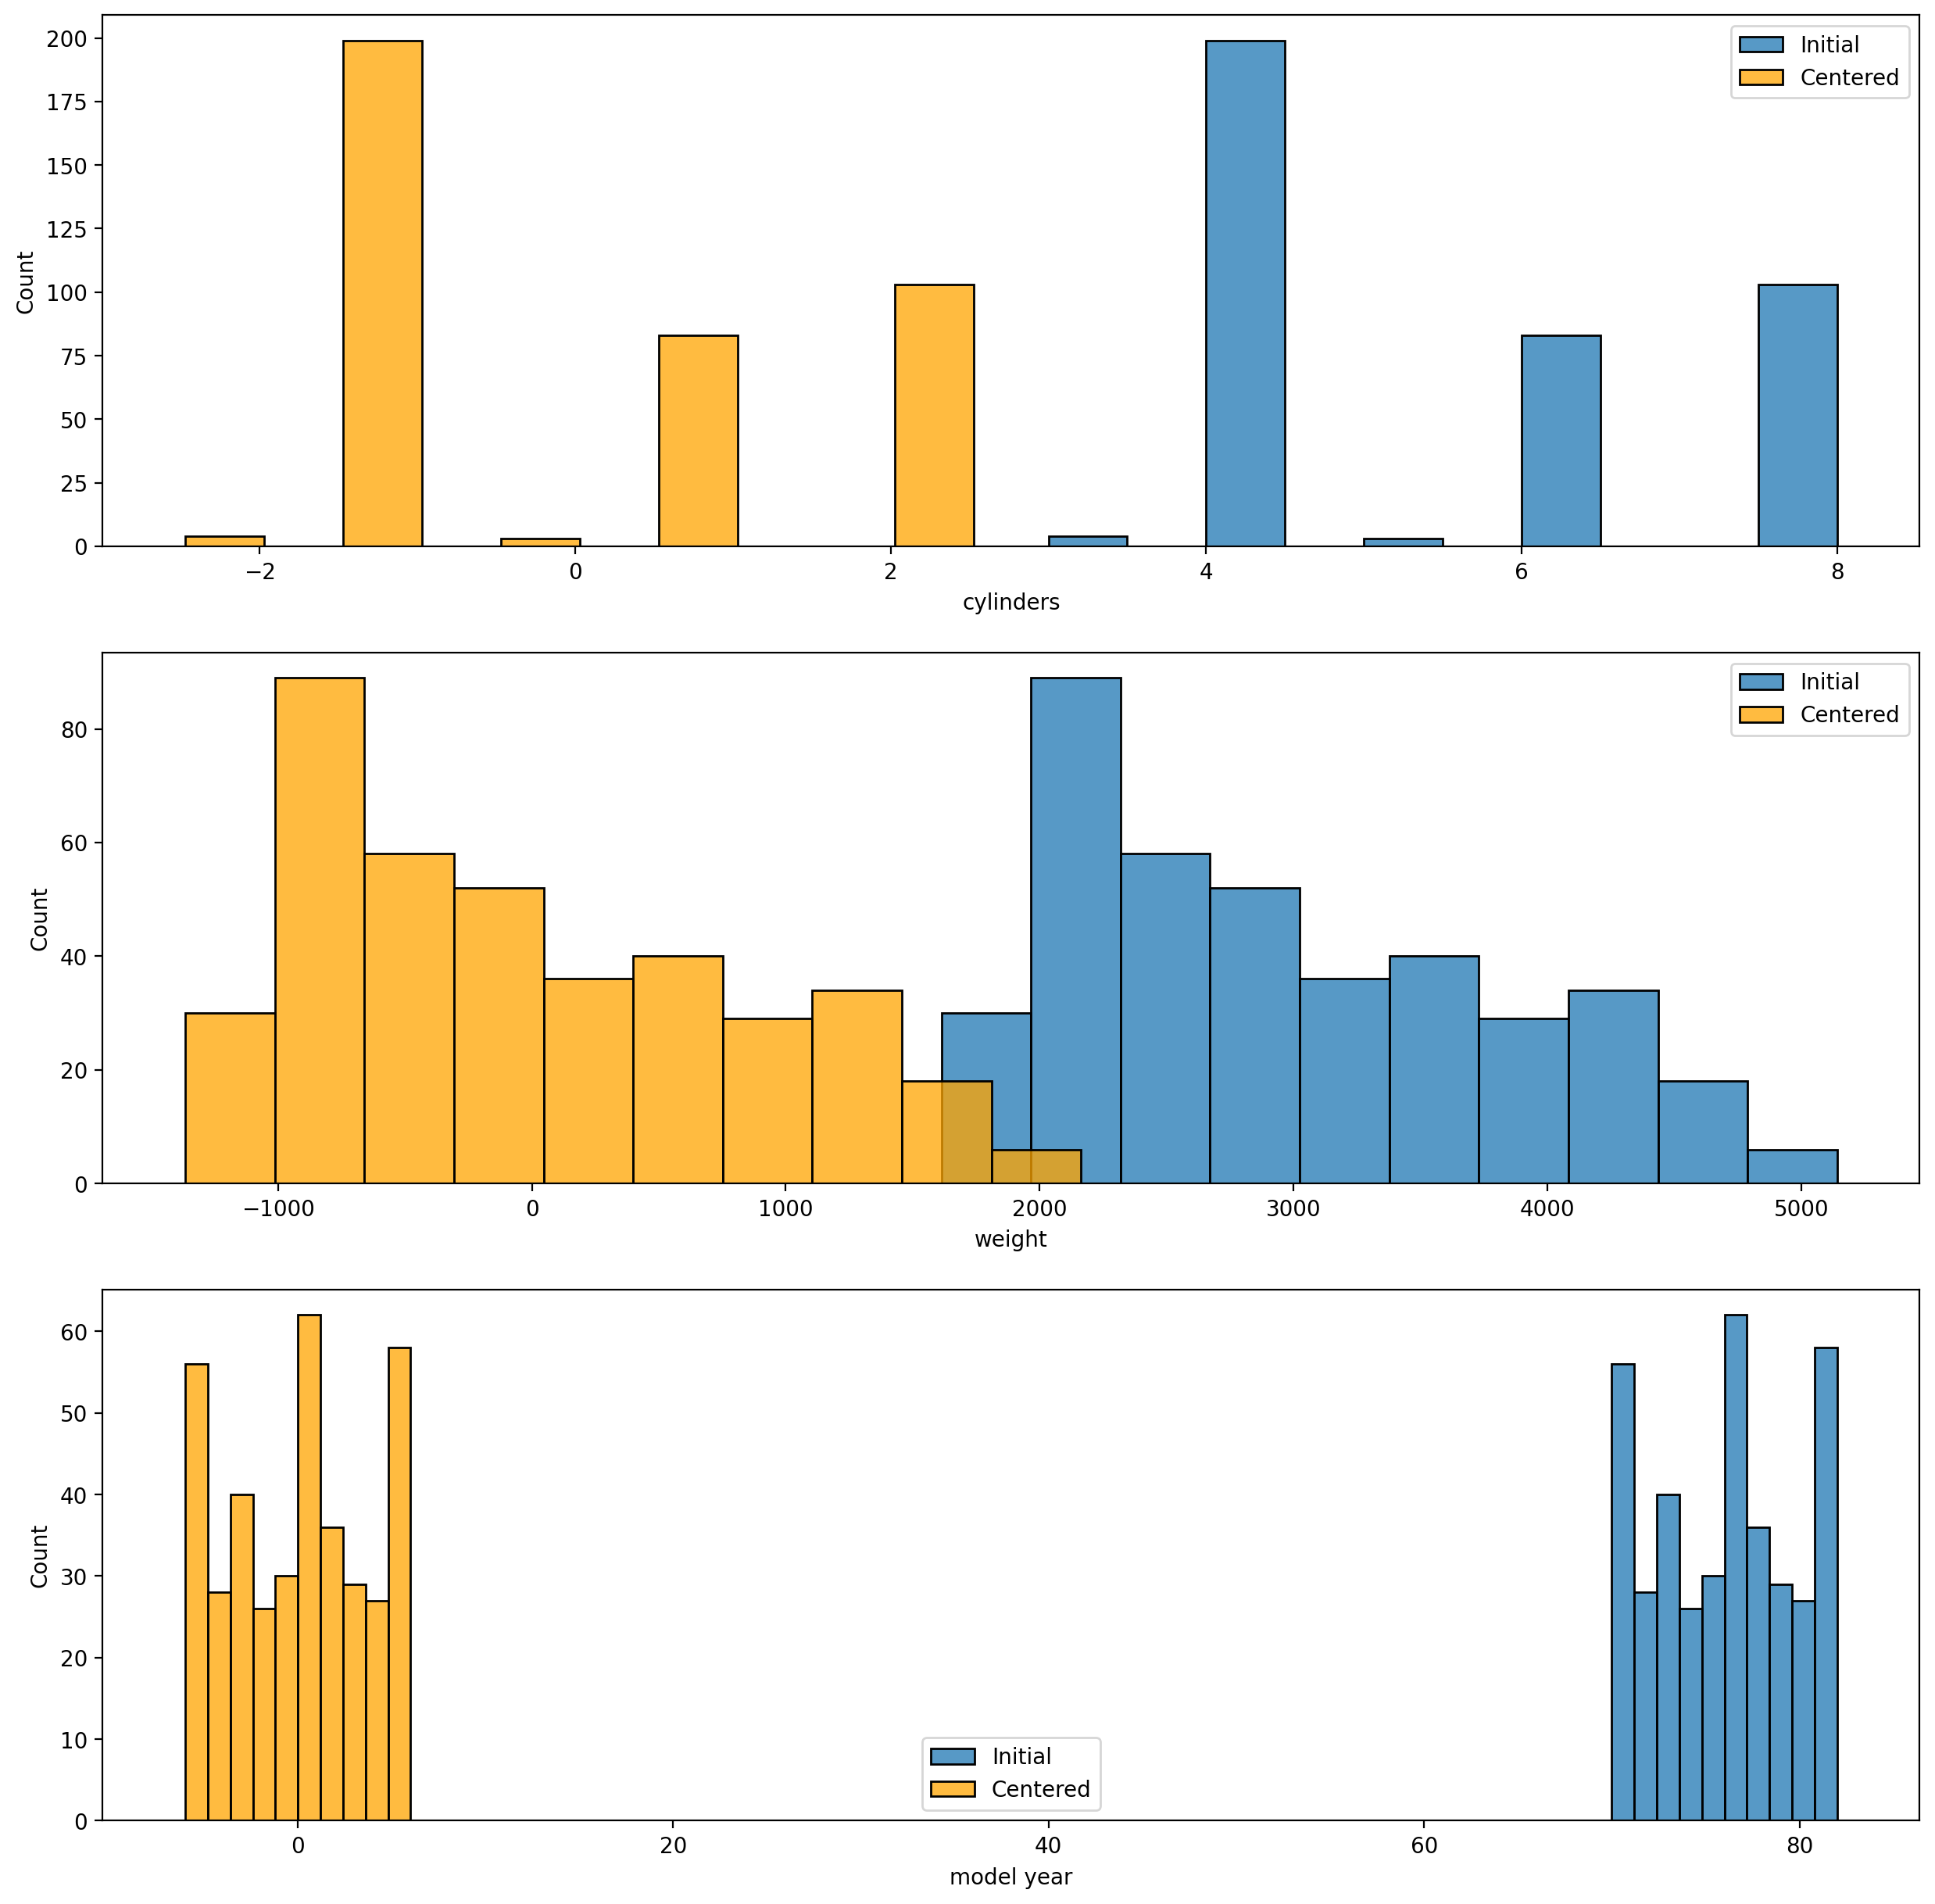

In [29]:
fig, axes = plt.subplots(nrows=3, figsize=(15,15))

for index, col in enumerate(X_initial.columns):
    sns.histplot(data=X_initial, x=col, label="Initial", ax=axes[index])
    sns.histplot(data=X_centered, x=col, label="Centered", color="orange", ax=axes[index])
    axes[index].legend()

Note that the means of each column went from about 5.5, about 3k, and about 76 to being about 0 for each. (Due to floating point rounding the actual means are very small positive or negative values, but you can consider them to equal 0.)

The counts and standard deviations are the same, but the minimum, maximum, and percentile values are also shifted to reflect the new mean.

Let's build a model with these centered predictors:

In [30]:
centered_model = sm.OLS(y_initial, sm.add_constant(X_centered))
centered_results = centered_model.fit()

print(f"""
Initial model adjusted R-Squared:  {initial_results.rsquared_adj}
Centered model adjusted R-Squared: {centered_results.rsquared_adj}
""")


Initial model adjusted R-Squared:  0.8069069309563752
Centered model adjusted R-Squared: 0.8069069309563753



In [31]:
initial_results.params

const        -13.907606
cylinders     -0.151729
weight        -0.006366
model year     0.752020
dtype: float64

In [32]:
centered_results.params

const         23.445918
cylinders     -0.151729
weight        -0.006366
model year     0.752020
dtype: float64

As expected, our coefficients for the predictors are the same. For example, for each increase of 1 lb in weight, we see an associated decrease of about 0.006 in MPG.

However we now have a more meaningful intercept. In our initial model, the intercept interpretation was this:

> For a car with 0 cylinders, weighing 0 lbs, and built in 1900, we would expect an MPG of about -13.9

That is an impossible MPG, for an impossible car.

In our zero-centered model, the intercept interpretation is this:

> For a car with the average number of cylinders, average weight, and average model year, we would expect an MPG of about 23.4

That makes a lot more sense! Now the intercept is something that might be worth reporting to stakeholders.

However you should also consider that this "average" car might be impossible as well. For example, if we look at the `cylinders` average, it is: 

In [33]:
data["cylinders"].mean()

5.471938775510204

Can a car actually have 5.5 cylinders? Probably not! So this intercept interpretation is really only 100% realistic if all of the predictors are _continuous_ variables. But you still may find it relevant for stakeholders, so long as you report it with the right caveats.

## Standardizing: Centering + Scaling

Standardization is a combination of zero-centering the variables and dividing by the standard deviation.

$$x' = \dfrac{x - \bar x}{\sigma}$$

After performing this transformation, $x'$ will have mean of 0 and a standard deviation of 1.

In [34]:
X_initial.describe()

,cylinders,weight,model year
count,392.000000,392.000000,392.000000
mean,5.471939,2977.584184,75.979592
std,1.705783,849.402560,3.683737
min,3.000000,1613.000000,70.000000
25%,4.000000,2225.250000,73.000000
50%,4.000000,2803.500000,76.000000
75%,8.000000,3614.750000,79.000000
max,8.000000,5140.000000,82.000000


In [35]:
X_standardized = X_initial.copy()

for col in X_standardized:
    X_standardized[col] = (X_standardized[col] - X_standardized[col].mean()) \
                            / X_standardized[col].std()
    

X_standardized.describe()

,cylinders,weight,model year
count,3.920000e+02,3.920000e+02,3.920000e+02
mean,-7.250436e-17,3.625218e-17,-1.232574e-15
std,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.449152e+00,-1.606522e+00,-1.623241e+00
25%,-8.629108e-01,-8.857216e-01,-8.088504e-01
50%,-8.629108e-01,-2.049490e-01,5.540071e-03
75%,1.482053e+00,7.501341e-01,8.199306e-01
max,1.482053e+00,2.545808e+00,1.634321e+00


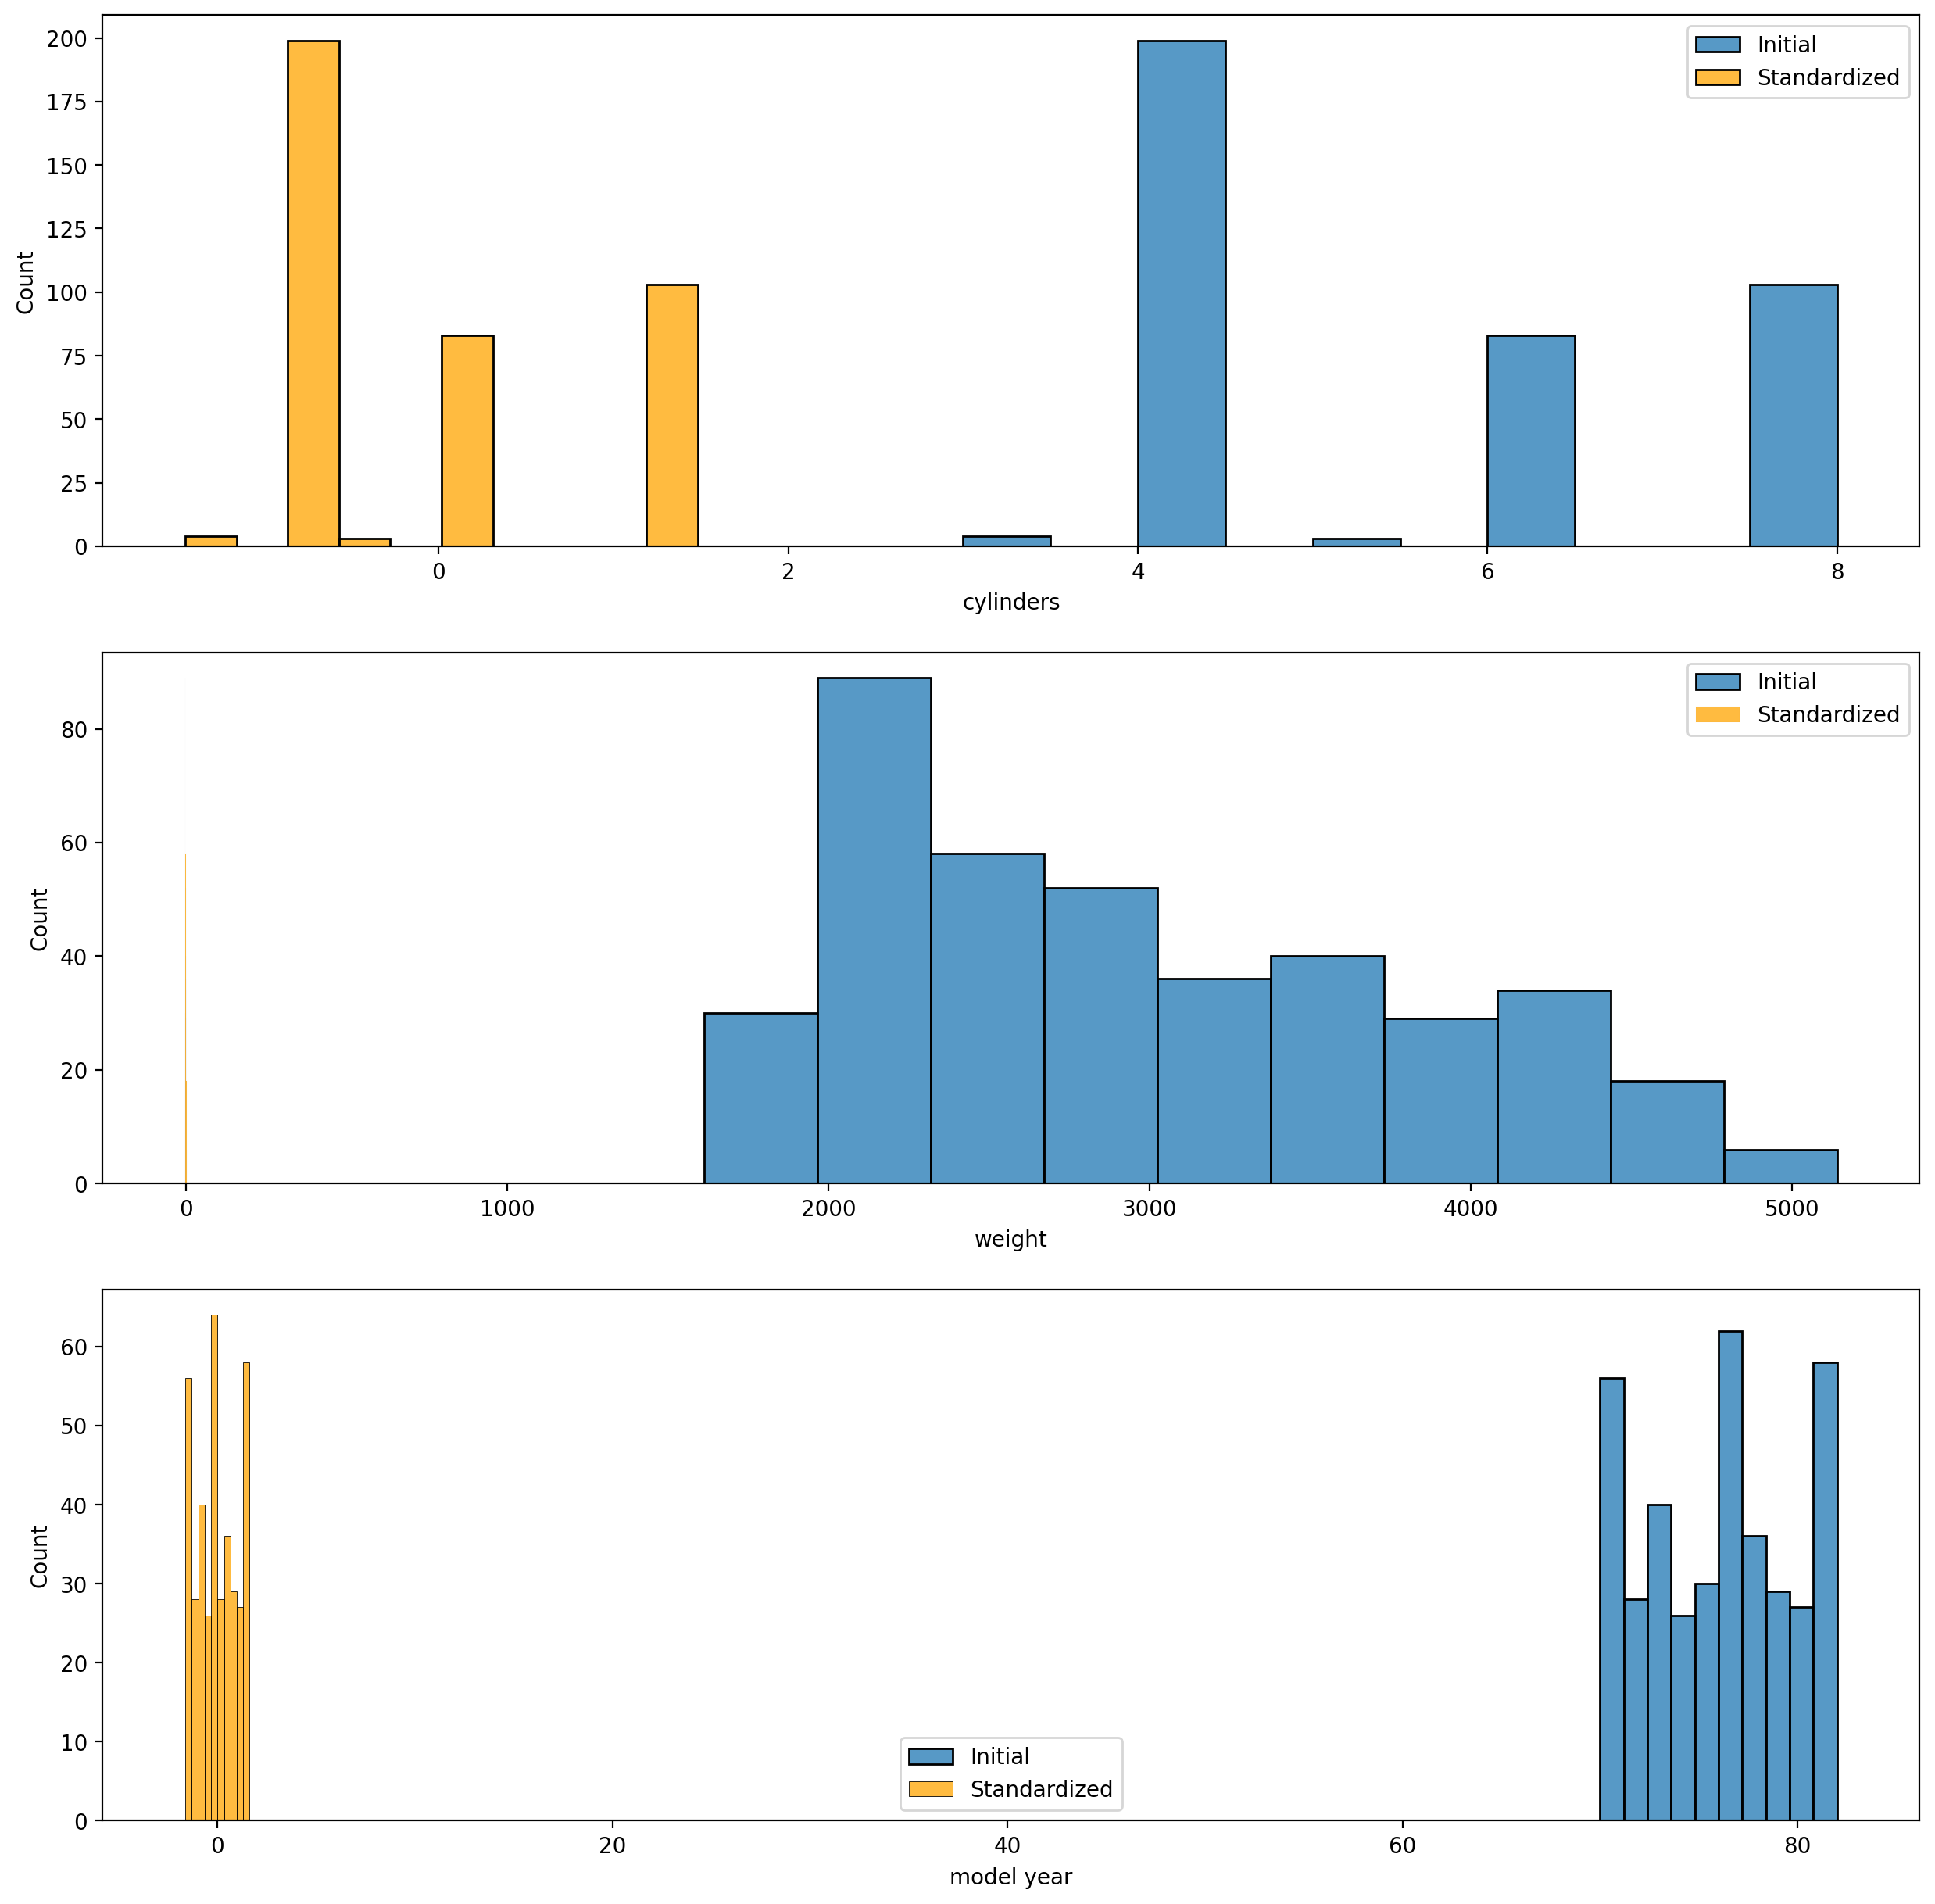

In [36]:
fig, axes = plt.subplots(nrows=3, figsize=(15,15))

for index, col in enumerate(X_initial.columns):
    sns.histplot(data=X_initial, x=col, label="Initial", ax=axes[index])
    sns.histplot(
        data=X_standardized,
        x=col,
        label="Standardized",
        color="orange",
        ax=axes[index]
    )
    axes[index].legend()

In linear regression analysis, the most common reason for standardizing data is so that you can **compare the coefficients to each other**.

In our centered model, the coefficients are all using different units:

In [37]:
centered_results.params

const         23.445918
cylinders     -0.151729
weight        -0.006366
model year     0.752020
dtype: float64

`model year` has the largest magnitude, but can we say that it "matters most" or "has the most impact"? Probably not, because it is measured in years whereas the other features are measured in cylinders and pounds. How can we compare those?

Standardization changes the units of the coefficients so that they are in standard deviations rather than the specific units of each predictor. This allows us to make just that comparison:

In [38]:
standardized_model = sm.OLS(y_initial, sm.add_constant(X_standardized))
standardized_results = standardized_model.fit()

print(f"""
Centered model adjusted R-Squared:     {centered_results.rsquared_adj}
Standardized model adjusted R-Squared: {standardized_results.rsquared_adj}
""")


Centered model adjusted R-Squared:     0.8069069309563753
Standardized model adjusted R-Squared: 0.8069069309563751



In [39]:
standardized_results.params

const         23.445918
cylinders     -0.258817
weight        -5.407040
model year     2.770244
dtype: float64

We have the same intercept as the zero-centered model (since this model's features were also centered), but now the coefficients look quite different. We can interpret them like this:

> For each increase of 1 standard deviation in the number of cylinders, we see an associated decrease of about 0.26 MPG

> For each increase of 1 standard deviation in the weight, we see an associated decrease of about 5.4 MPG

> For each increase of 1 standard deviation in the model year, we see an associated increase of about 2.8 MPG

Comparing these three, we can conclude that `weight` "is the most important" or "has the most impact" because it has the largest coefficient. This might be surprising because the previous model had the _smallest_ coefficient for `weight`, but that was because it was measured in pounds, with a much _larger_ standard deviation than the other two predictors:

In [40]:
data["weight"].std()

849.4025600429492

In [41]:
data["cylinders"].std()

1.7057832474527845

In [42]:
data["model year"].std()

3.6837365435778295

(Every model is different, and sometimes the largest coefficient before standardizing will also be the largest after standardizing. This is just an example of how much of a difference it can make!)

Also, just like you can get transformed coefficients from un-transformed data by applying the inverse of the transformation, **you can get un-transformed coefficients from transformed data by applying the same transformation to the coefficient**.

For example, let's say you have this standardized model as your final model, because you knew that stakeholders would want to know which feature was most important:

In [43]:
standardized_results.params

const         23.445918
cylinders     -0.258817
weight        -5.407040
model year     2.770244
dtype: float64

You have answered the question about which is most important (`weight`) but now the stakeholder wants you to interpret the coefficient. You start to say "Each increase of 1 standard deviation..." but that is too confusing. A typical business stakeholder might not have a clear sense of what a "standard deviation" is.

Fortunately to get those coefficients to be the same as the un-transformed version (i.e. units of cylinders, pounds, and years respectively), just divide each of them by the standard deviation:

In [44]:
standardized_results.params["cylinders"] / data["cylinders"].std()

-0.15172901259380814

In [45]:
standardized_results.params["weight"] / data["weight"].std()

-0.006365697499915218

In [46]:
standardized_results.params["model year"] / data["model year"].std()

0.7520200488347164

These are now the same as the initial model params!

In [47]:
initial_results.params[1:]

cylinders    -0.151729
weight       -0.006366
model year    0.752020
dtype: float64

## Other Popular Transformations

We won't go through code examples for them, but it's helpful to be aware that there are other transformations you might see.

### Min-Max Scaling

When performing min-max scaling, you can transform x to get the transformed $x'$ by using the formula:

$$x' = \dfrac{x - \min(x)}{\max(x)-\min(x)}$$

This way of scaling brings all values between 0 and 1. There are also implementations that bring in ranges other than 0 to 1 by performing an extra scaling step.

### Mean Normalization

When performing mean normalization, you use the following formula:

$$x' = \dfrac{x - \text{mean}(x)}{\max(x)-\min(x)}$$

The distribution will have values between -1 and 1, and a mean of 0.

### Unit Vector Transformation

When performing unit vector transformations, you use the following formula:

$$x'= \dfrac{x}{{||x||}}$$

Recall that the norm of x $||x||= \sqrt{(x_1^2+x_2^2+...+x_n^2)}$.

This will also create a distribution between 0 and 1.

## Additional Information

Scikit-learn provides tools to apply various feature transformations:

* [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) standardizes data
* [`RobustScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html) uses quantiles rather than the mean to center and scale data
* [`MinMaxScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) applies min-max scaling
* [`Normalizer`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html) applies unit vector transformations

Have a look at these built-in functions and some code examples [here](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing)!

To learn more about feature scaling in general, you can have a look at this blog post: https://sebastianraschka.com/Articles/2014_about_feature_scaling.html (up until "bottom-up approaches").

## Summary

In this lesson, you learned about why linear transformations are useful, how to apply them, and how to interpret the resulting coefficients.